# Разметка частей речи с использованием BiLSTM

In [1]:
import re
import nltk
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from nltk.corpus import treebank, brown, conll2000
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import (
    pad_sequence,
    pack_padded_sequence,
    pad_packed_sequence,
)
from tqdm import tqdm

## Датасет

Сложно найти открытый датасет с размеченными частями речи, так как создать такой набор данных трудоемкая задача.

К счастью, в `nltk` есть несколько таких наборов данных:
- `treebank`
- `brown`
- `conll2000`

In [2]:
nltk.download("treebank")
nltk.download("brown")
nltk.download("conll2000")

[nltk_data] Downloading package treebank to /home/misha/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /home/misha/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/misha/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

В таком виде они используют разные наборы тегов. Чтобы привести их одну, необходимо загрузить `universal_tagset`.

In [3]:
nltk.download("universal_tagset")

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/misha/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
tagged_sentences = (
    treebank.tagged_sents(tagset="universal")
    + brown.tagged_sents(tagset="universal")
    + conll2000.tagged_sents(tagset="universal")
)

print(tagged_sentences[0])
print(f"Размер датасета: {len(tagged_sentences)}")

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
Размер датасета: 72202


## Train-Test-Validation Split

Каждое предложение - это последовательность кортежей слово-часть_речи.

- Вход модели - последовательность слов;
- Выход модели - последовательность PoS теги (метки частей речи (PoS - part-of-speech))

Поэтому необходимо разделить входные последовательности от выходных.

In [5]:
sentences, sentence_tags = [], []

for s in tagged_sentences:
    sentence, tags = zip(*s)
    sentences.append(list(sentence))
    sentence_tags.append(list(tags))

In [6]:
print(sentences[0])
print(sentence_tags[0])
print(len(sentences), len(sentence_tags))

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']
72202 72202


Делим на обучающую, валидационную и тестовую выборки.

In [7]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(
    sentences, sentence_tags, test_size=1 - train_ratio, random_state=1
)

x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=1,
)

In [8]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

54151 54151
10830 10830
7221 7221


## Векторизация

In [9]:
class Vocab:
    def __init__(
        self, unk_token: str | None = "<unk>", pad_token: str | None = "<pad>"
    ):
        self.unk = unk_token
        self.pad = pad_token
        self.word_index = {}
        self.index_word = {}

        self.num_specials = 0
        if self.pad:
            self.word_index[self.pad] = self.num_specials
        if self.unk:
            self.num_specials += 1
            self.word_index[self.unk] = self.num_specials

    def fit(self, texts):
        words = set()
        for sequence in texts:
            words.update(sequence)

        self.word_index.update(
            (word, i)
            for i, word in enumerate(words, start=self.num_specials + 1)
        )

        self.index_word = {i: word for word, i in self.word_index.items()}

    def texts_to_sequences(self, texts: list[list[str]]) -> list[torch.Tensor]:
        """
        Returns:
            list[torch.Tensor]: list of tensors shape (num_words,), dtype=torch.long
        """
        if self.unk:
            return [
                torch.tensor(
                    [
                        self.word_index.get(word, self.word_index[self.unk])
                        for word in text
                    ],
                    dtype=torch.long,
                )
                for text in texts
            ]
        else:
            return [
                torch.tensor(
                    [self.word_index[word] for word in text],
                    dtype=torch.long,
                )
                for text in texts
            ]

    def sequences_to_texts(
        self, sequences: list[list[int]] | list[torch.Tensor]
    ) -> list[list[str]]:
        return [
            [self.index_word[index] for index in sequence.tolist()]
            for sequence in sequences
        ]


In [10]:
sentence_tokenizer = Vocab()
sentence_tokenizer.fit(x_train)
print(f"Размер словаря: {len(sentence_tokenizer.word_index)}")

Размер словаря: 58535


In [11]:
tag_tokenizer = Vocab(unk_token=None, pad_token=None)
tag_tokenizer.fit(y_train)
print(f"Число частей речи: {len(tag_tokenizer.word_index)}\n")

Число частей речи: 12



In [12]:
tag_tokenizer.word_index

{'ADP': 1,
 'NUM': 2,
 'PRT': 3,
 'ADJ': 4,
 'NOUN': 5,
 'ADV': 6,
 'PRON': 7,
 'VERB': 8,
 '.': 9,
 'DET': 10,
 'CONJ': 11,
 'X': 12}

Теперь можем получать последовательности индексов слов по списку слов.

In [13]:
x_train_seqs = sentence_tokenizer.texts_to_sequences(x_train)

In [14]:
print(x_train_seqs[0])

tensor([46248, 36907, 13556, 31977, 38230, 42994, 20022, 36783, 41235,  9632,
        22841, 21402,  6277])


А также получать список слов по последовательности индексов.

In [15]:
print(f"Оригинал: {x_train[0]}")
print(
    f"Востановленный: {sentence_tokenizer.sequences_to_texts([x_train_seqs[0]])}"
)

Оригинал: ['This', 'may', 'be', 'due', 'to', 'the', 'heavy', 'interlobular', 'connective', 'tissue', 'barriers', 'present', '.']
Востановленный: [['This', 'may', 'be', 'due', 'to', 'the', 'heavy', 'interlobular', 'connective', 'tissue', 'barriers', 'present', '.']]


Теперь преобразуем метки.

In [16]:
y_train_seqs = tag_tokenizer.texts_to_sequences(y_train)

In [17]:
tag_tokenizer.sequences_to_texts([y_train_seqs[0]])

[['DET',
  'VERB',
  'VERB',
  'ADJ',
  'ADP',
  'DET',
  'ADJ',
  'ADJ',
  'ADJ',
  'NOUN',
  'NOUN',
  'ADV',
  '.']]

А также преобразуем валидационную выборку.

In [18]:
x_val_seqs = sentence_tokenizer.texts_to_sequences(x_val)
y_val_seqs = tag_tokenizer.texts_to_sequences(y_val)

## Padding

Хотя RNN может принимать последовательности разной длины, их все равно придется привести к одной длине, так как записи в тензоре батча не могут быть переменной длины.

Лучше всего отсортировать тренировочный набор, и дополнять нулями до значения, соответствующего длине наибольшей последовательности.

На этот раз, мы сделаем **все** тензоры равным по длине максимальному.

In [19]:
MAX_LENGTH = len(max(x_train_seqs, key=len))
MIN_LENGTH = len(min(x_train_seqs, key=len))
print("Длина максимальной последовательности:", MAX_LENGTH)
print("Длина минимальной последовательности:", MIN_LENGTH)

Длина максимальной последовательности: 161
Длина минимальной последовательности: 1


In [20]:
PAD_IDX = 0
x_train_padded = pad_sequence(
    x_train_seqs, batch_first=True, padding_value=PAD_IDX
)

In [21]:
print(x_train_padded[0])

tensor([46248, 36907, 13556, 31977, 38230, 42994, 20022, 36783, 41235,  9632,
        22841, 21402,  6277,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

Теперь для `y_train`

In [22]:
y_train_padded = pad_sequence(
    y_train_seqs, batch_first=True, padding_value=PAD_IDX
).long()

Необходимо также сохранить длины последовательностей для использования их в `pack_padded_sequence, pad_packed_sequence`.

In [23]:
train_lengths = torch.tensor(
    [len(seq) for seq in x_train_seqs], dtype=torch.long
)

И валидационная выборка.

In [24]:
x_val_padded = pad_sequence(
    x_val_seqs, batch_first=True, padding_value=PAD_IDX
)
y_val_padded = pad_sequence(
    y_val_seqs, batch_first=True, padding_value=PAD_IDX
).long()
val_lengths = torch.tensor([len(seq) for seq in x_val_seqs], dtype=torch.long)

In [25]:
y_val_padded[0].dtype

torch.int64

## Модель

In [26]:
class PoSDataset(data.Dataset):
    def __init__(
        self, x: torch.Tensor, y: torch.Tensor, lengths: torch.Tensor
    ):
        super().__init__()
        self.x = x
        self.y = y
        self.lengths = lengths
        self.length = x.size(0)

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.lengths[index]

    def __len__(self):
        return self.length


class PoSModel(nn.Module):
    def __init__(
        self, num_classes, num_embeddings, embedding_dim=128, padding_idx=0
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_dim, padding_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            embedding_dim,
            bidirectional=True,
            batch_first=True,
        )
        self.out = nn.Linear(embedding_dim * 2, num_classes)
        # nn.Softmax в CrossEntropy есть

    def forward(self, x, lengths):
        # x: (batch_size, seq_length)
        embeddings = self.embedding(x)
        # embeddings: (batch_size, seq_length, embedding_dim)
        packed_embeddings = pack_padded_sequence(
            embeddings, lengths, batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed_embeddings)
        # packed_out: (batch_size, lengths, out)
        out, out_lengths = pad_packed_sequence(
            packed_out, batch_first=True, total_length=x.size(1)
        )

        out = self.out(out)
        return out


## Обучение модели

In [27]:
class PoSTrainer:
    def __init__(
        self,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: data.DataLoader,
        val_dataloader: data.DataLoader,
        epochs: int,
        patience: int,
        device: torch.device,
    ):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.patience = patience
        self.device = device

    def compute_metrics(self, y_pred, y_true):
        return {"accuracy": accuracy_score(y_true, y_pred)}

    def _run_epoch(self, dataloader, train: bool = True):
        if train:
            self.model.train()
        else:
            self.model.eval()

        epoch_loss = 0.0
        epoch_predicts = []
        epoch_labels = []

        ctx = torch.enable_grad() if train else torch.no_grad()
        with ctx:
            for X, y, lengths in tqdm(
                dataloader, desc="Train" if train else "Val"
            ):
                X, y = X.to(self.device), y.to(self.device)
                lengths = lengths.cpu()

                outputs = self.model(
                    X, lengths
                )  # (batch, seq_len, num_classes)
                loss = self.criterion(outputs.permute(0, 2, 1), y)

                if train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                epoch_loss += loss.item()

                predicts = outputs.detach().cpu().argmax(dim=-1).numpy()
                labels = y.detach().cpu().numpy()
                mask = labels != PAD_IDX
                if mask.any():
                    epoch_predicts.extend(predicts[mask])
                    epoch_labels.extend(labels[mask])

        epoch_loss /= len(dataloader)
        metrics = self.compute_metrics(epoch_predicts, epoch_labels)
        return epoch_loss, metrics

    def _train_epoch(self):
        return self._run_epoch(self.train_dataloader, train=True)

    def _validate(self, dataloader=None):
        if dataloader is None:
            dataloader = self.val_dataloader
        return self._run_epoch(dataloader, train=False)

    def test(
        self, test_dataloader: data.DataLoader
    ) -> tuple[float, dict[str, float | int]]:
        return self._validate(test_dataloader)

    def __append_to_history(self, **kwargs):
        for k in self.history:
            self.history[k].append(kwargs[k])

    def train(self):
        self.history = dict(
            train_loss=[], val_loss=[], train_accuracy=[], val_accuracy=[]
        )
        best_score = 0
        no_improve = 0
        best_model = {
            k: v.cpu().clone() for k, v in self.model.state_dict().items()
        }
        for epoch in range(self.epochs):
            train_loss, train_metrics = self._train_epoch()
            val_loss, val_metrics = self._validate()
            self.__append_to_history(
                train_loss=train_loss,
                train_accuracy=train_metrics["accuracy"],
                val_loss=val_loss,
                val_accuracy=val_metrics["accuracy"],
            )

            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(
                f"Train Loss:      {train_loss:.3f}, "
                f"Train Accuracy:      {train_metrics['accuracy']:.3f}"
            )
            print(
                f"Validation Loss: {val_loss:.3f}, "
                f"Validation Accuracy: {val_metrics['accuracy']:.3f}"
            )
            print()
            if val_metrics["accuracy"] > best_score:
                best_score = val_metrics["accuracy"]
                best_model = {
                    k: v.cpu().clone()
                    for k, v in self.model.state_dict().items()
                }
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= self.patience:
                print(f"Early stopping after {epoch + 1} epoch")
                self.model.load_state_dict(best_model)
                break

        print(f"Best Accuracy: {best_score:.4f}")
        return self.history

In [28]:
model = PoSModel(
    num_classes=len(tag_tokenizer.word_index) + 1,
    num_embeddings=len(sentence_tokenizer.word_index),
    embedding_dim=128,
    padding_idx=PAD_IDX,
)

train_dataset = PoSDataset(x_train_padded, y_train_padded, train_lengths)
val_dataset = PoSDataset(x_val_padded, y_val_padded, val_lengths)

train_dataloader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

trainer = PoSTrainer(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    epochs,
    patience,
    device,
)

Device: cuda


In [29]:
history = trainer.train()

Val: 100%|██████████| 677/677 [00:02<00:00, 238.93it/s]


Epoch 1/20
Train Loss:      0.295, Train Accuracy:      0.907
Validation Loss: 0.156, Validation Accuracy: 0.947



Val: 100%|██████████| 677/677 [00:02<00:00, 251.99it/s]


Epoch 2/20
Train Loss:      0.113, Train Accuracy:      0.963
Validation Loss: 0.122, Validation Accuracy: 0.958



Val: 100%|██████████| 677/677 [00:02<00:00, 266.52it/s]


Epoch 3/20
Train Loss:      0.068, Train Accuracy:      0.978
Validation Loss: 0.112, Validation Accuracy: 0.962



Val: 100%|██████████| 677/677 [00:02<00:00, 235.01it/s]


Epoch 4/20
Train Loss:      0.041, Train Accuracy:      0.987
Validation Loss: 0.132, Validation Accuracy: 0.960



Val: 100%|██████████| 677/677 [00:02<00:00, 257.30it/s]


Epoch 5/20
Train Loss:      0.025, Train Accuracy:      0.992
Validation Loss: 0.132, Validation Accuracy: 0.963



Val: 100%|██████████| 677/677 [00:02<00:00, 270.28it/s]


Epoch 6/20
Train Loss:      0.016, Train Accuracy:      0.995
Validation Loss: 0.133, Validation Accuracy: 0.965



Val: 100%|██████████| 677/677 [00:02<00:00, 265.02it/s]


Epoch 7/20
Train Loss:      0.010, Train Accuracy:      0.997
Validation Loss: 0.172, Validation Accuracy: 0.960



Val: 100%|██████████| 677/677 [00:03<00:00, 215.68it/s]


Epoch 8/20
Train Loss:      0.007, Train Accuracy:      0.998
Validation Loss: 0.178, Validation Accuracy: 0.962



Val: 100%|██████████| 677/677 [00:02<00:00, 246.98it/s]

Epoch 9/20
Train Loss:      0.006, Train Accuracy:      0.998
Validation Loss: 0.201, Validation Accuracy: 0.960

Early stopping after 9 epoch
Best Accuracy: 0.9648


In [30]:
import matplotlib.pyplot as plt


def plot_history(history: dict[list]):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

    ax1.plot(history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(history["train_accuracy"], label="Train Accuracy", color="blue")
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="red")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()
    ax2.grid()

    fig.suptitle("Model Training Metrics", fontsize=16)

    fig.tight_layout(pad=2)
    plt.show()

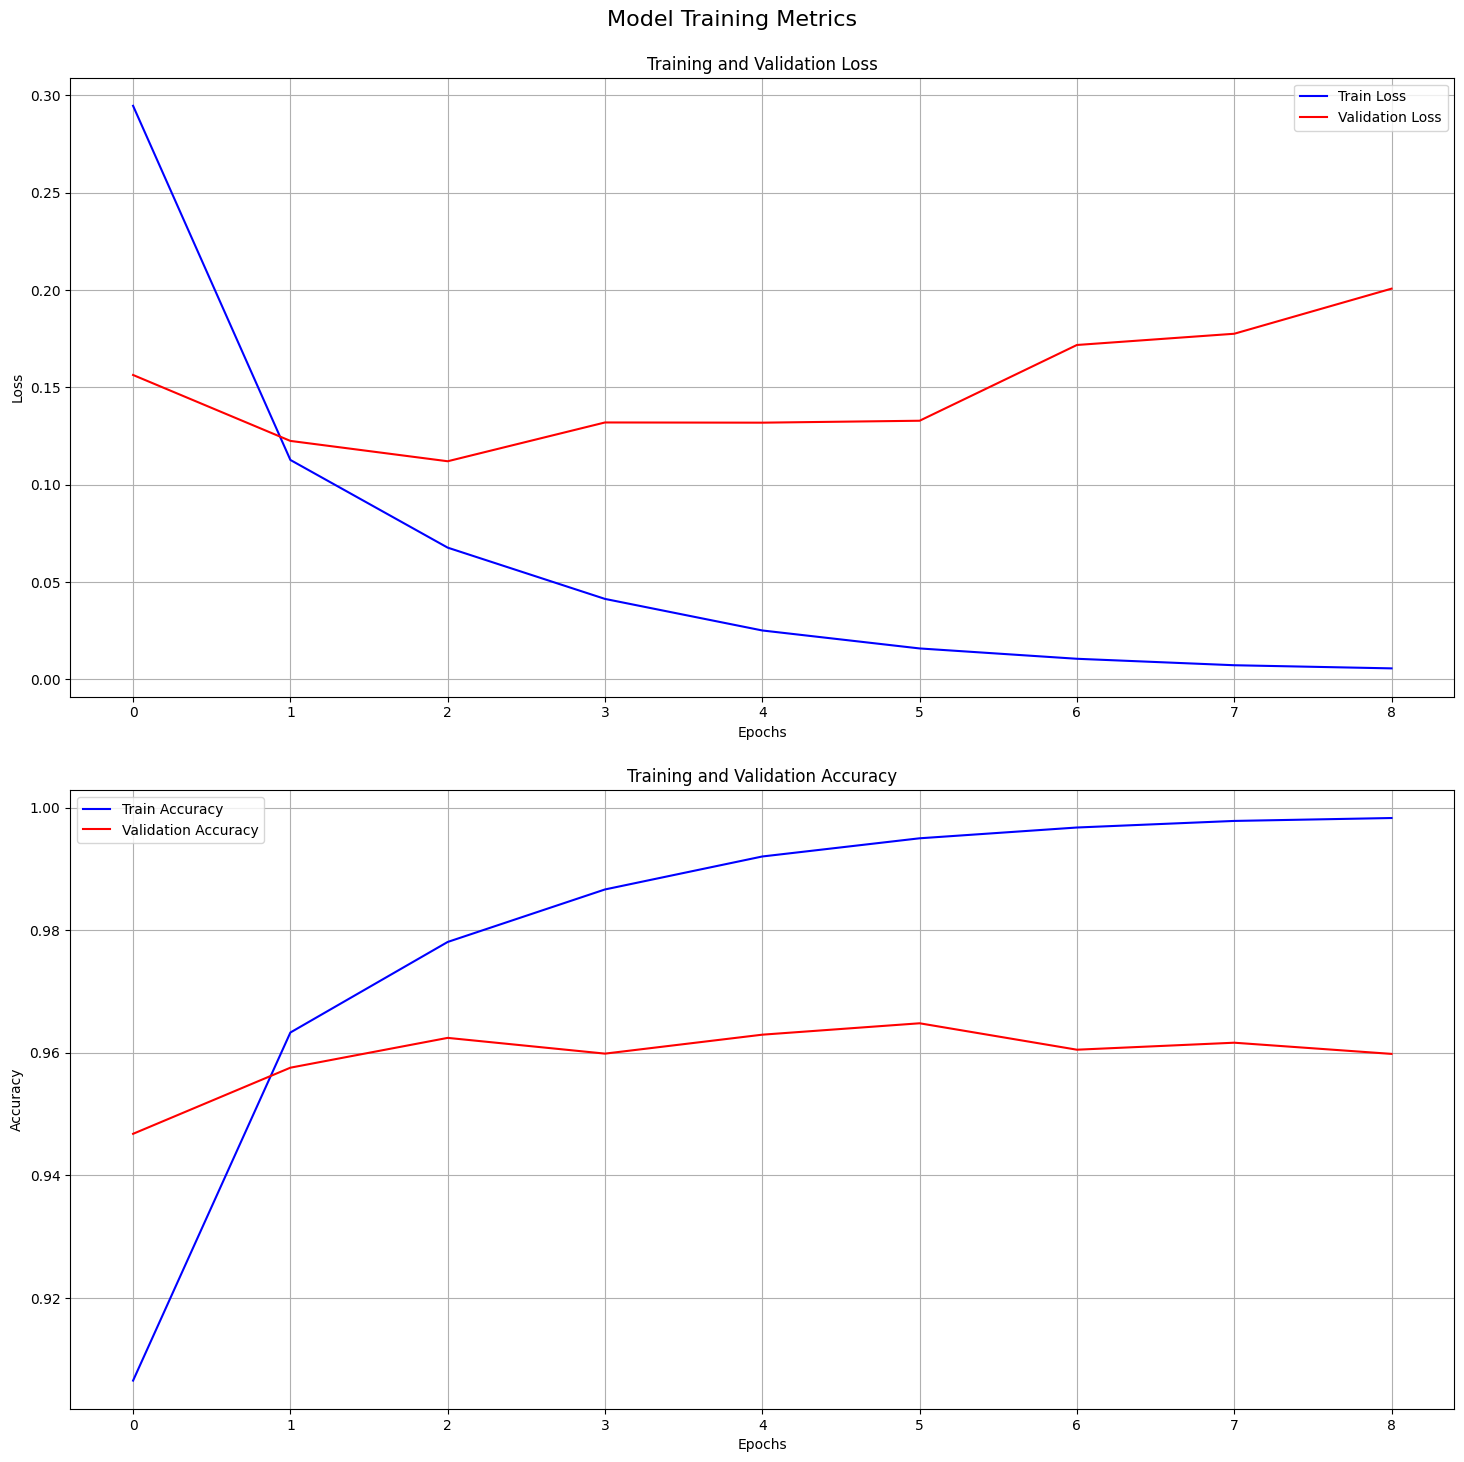

In [31]:
plot_history(history)

## Тестирование

In [32]:
x_test_seqs = sentence_tokenizer.texts_to_sequences(x_test)
y_test_seqs = tag_tokenizer.texts_to_sequences(y_test)

x_test_padded = pad_sequence(
    x_test_seqs, batch_first=True, padding_value=PAD_IDX
)
y_test_padded = pad_sequence(
    y_test_seqs, batch_first=True, padding_value=PAD_IDX
).long()

test_lengths = torch.tensor(
    [len(seq) for seq in x_test_seqs], dtype=torch.long
)

In [33]:
test_dataset = PoSDataset(x_test_padded, y_test_padded, test_lengths)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False)
loss, metrics = trainer.test(test_dataloader)

Val: 100%|██████████| 452/452 [00:01<00:00, 263.63it/s]


In [34]:
print(f"Test Loss:     {loss:.3f}")
print(f"Test Accuracy: {metrics['accuracy']:.3f}")

Test Loss:     0.138
Test Accuracy: 0.965


## Инференс

Теперь можем использовать модель для разметки частей речи

In [35]:
samples = [
    "Brown refused to testify.",
    "Brown sofas are on sale.",
    "Are you kidding me? I mean - wtf, man",
]

In [36]:
import spacy

nlp = spacy.blank("en")


def spacy_tokenizer(string):
    return [t.text for t in nlp(string)]


def tag_sentences(sentences: list[str]):
    tokenized = [spacy_tokenizer(text) for text in sentences]
    sentences_seqs = sentence_tokenizer.texts_to_sequences(tokenized)
    sentences_padded = pad_sequence(
        sentences_seqs, batch_first=True, padding_value=PAD_IDX
    )
    lengths = torch.tensor(
        [len(seq) for seq in sentences_padded], dtype=torch.long
    )

    model.eval()
    with torch.no_grad():
        # outputs: (batch_size, seq_len, num_classes)
        outputs = model(sentences_padded.to(device), lengths)
    # predicts: (batch_size, seq_len)
    predicts = outputs.detach().cpu().argmax(dim=-1).numpy()

    sentence_tags = []
    for i, predict in enumerate(predicts):
        words = [
            sentence_tokenizer.index_word[w]
            for w in sentences_seqs[i].tolist()
        ]
        tags = [
            tag_tokenizer.index_word[tag]
            for tag in predict[: sentences_seqs[i].size(0) + 1]
        ]
        sentence_tags.append(list(zip(words, tags)))

    return sentence_tags

In [37]:
tagged_sample_sentences = tag_sentences(samples)

In [38]:
print(tagged_sample_sentences[0])

[('Brown', 'ADJ'), ('refused', 'VERB'), ('to', 'PRT'), ('testify', 'VERB'), ('.', 'VERB')]


In [39]:
print(tagged_sample_sentences[1])

[('Brown', 'ADJ'), ('sofas', 'NOUN'), ('are', 'VERB'), ('on', 'ADP'), ('sale', 'NOUN'), ('.', '.')]


Более сильные теггеры используют больше данных и другие модели, такие как трансформеры.